Using device: cpu
Training set size: 60000
Test set size: 10000
CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1152, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

Total parameters: 688,586
Trainable parameters: 688,586
Starting training...
Training epoch: 1, Batch: 0/938, Loss: 2.344517
Traini

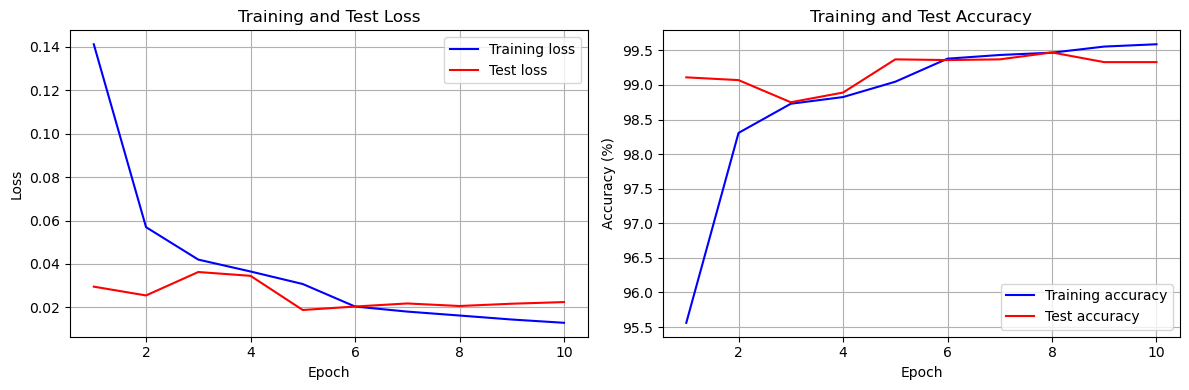

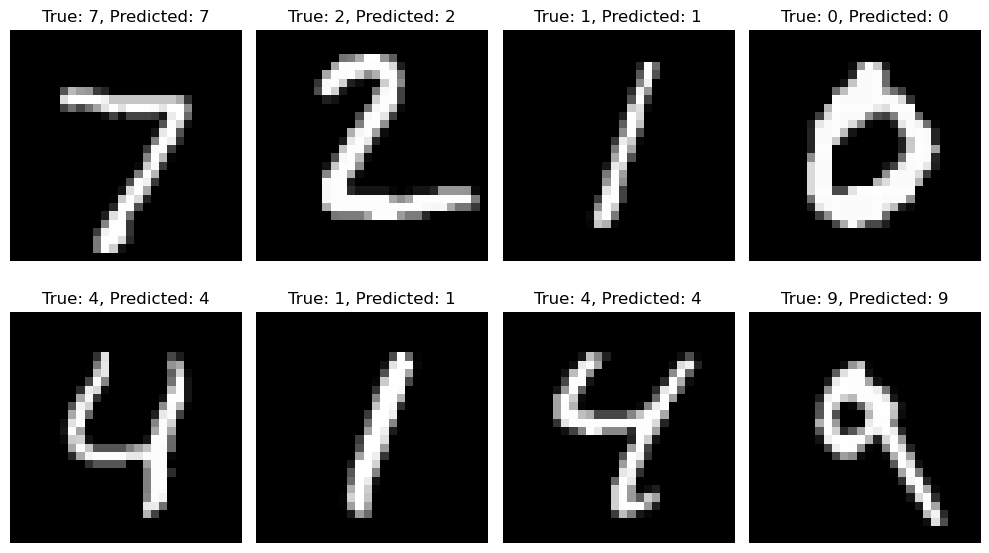

Model saved to mnist_cnn_model.pth
Training completed!
Final test accuracy: 99.33%


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to tensor and scale to [0,1]
    transforms.Normalize((0.1307,), (0.3081,))  # Mean and std of MNIST dataset
])

# Load datasets
train_dataset = datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)

test_dataset = datasets.MNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Training set size: {len(train_dataset)}')
print(f'Test set size: {len(test_dataset)}')

# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Convolutional layer 1: input 1 channel, output 32 channels, kernel size 3x3
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization
        
        # Convolutional layer 2: input 32 channels, output 64 channels, kernel size 3x3
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Convolutional layer 3: input 64 channels, output 128 channels, kernel size 3x3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Dropout layers to prevent overfitting
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        
        # Fully connected layers
        # 28x28 -> 14x14 -> 7x7 -> 3x3 (after 3 pooling operations)
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 10)  # 10 classes
        
    def forward(self, x):
        # First convolutional block
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 28x28 -> 14x14
        
        # Second convolutional block
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 14x14 -> 7x7
        
        # Third convolutional block
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # 7x7 -> 3x3
        
        # Dropout
        x = self.dropout1(x)
        
        # Flatten
        x = x.view(-1, 128 * 3 * 3)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

# Create model instance
model = CNN().to(device)
print(model)

# Calculate model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTotal parameters: {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')

# Define loss function and optimizer
criterion = nn.NLLLoss()  # Negative log likelihood loss, used with log_softmax
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

# Training function
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
        
        if batch_idx % 200 == 0:
            print(f'Training epoch: {epoch}, Batch: {batch_idx}/{len(train_loader)}, '
                  f'Loss: {loss.item():.6f}')
    
    accuracy = 100. * correct / total
    avg_loss = running_loss / len(train_loader)
    print(f'Training epoch {epoch}: Average loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')
    
    return avg_loss, accuracy

# Test function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({accuracy:.2f}%)\n')
    
    return test_loss, accuracy

# Train model
epochs = 10
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

print("Starting training...")
for epoch in range(1, epochs + 1):
    # Train
    train_loss, train_acc = train(model, device, train_loader, optimizer, epoch)
    
    # Test
    test_loss, test_acc = test(model, device, test_loader)
    
    # Update learning rate
    scheduler.step()
    
    # Record results
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

# Visualize training results
def plot_training_results():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss curves
    ax1.plot(range(1, epochs + 1), train_losses, 'b-', label='Training loss')
    ax1.plot(range(1, epochs + 1), test_losses, 'r-', label='Test loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Test Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy curves
    ax2.plot(range(1, epochs + 1), train_accuracies, 'b-', label='Training accuracy')
    ax2.plot(range(1, epochs + 1), test_accuracies, 'r-', label='Test accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Test Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Show some test sample predictions
def show_predictions(model, test_loader, num_samples=8):
    model.eval()
    
    # Get a batch of data
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(images)
        predictions = outputs.argmax(dim=1)
    
    # Visualize
    fig, axes = plt.subplots(2, 4, figsize=(10, 6))
    axes = axes.ravel()
    
    for i in range(num_samples):
        img = images[i].cpu().squeeze()
        true_label = labels[i].cpu().item()
        pred_label = predictions[i].cpu().item()
        
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'True: {true_label}, Predicted: {pred_label}')
        axes[i].axis('off')
        
        # If prediction is wrong, use red title
        if true_label != pred_label:
            axes[i].set_title(f'True: {true_label}, Predicted: {pred_label}', color='red')
    
    plt.tight_layout()
    plt.show()

# Save model
def save_model(model, path='mnist_cnn_model.pth'):
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_structure': model,
    }, path)
    print(f"Model saved to {path}")

# Load model
def load_model(path='mnist_cnn_model.pth'):
    checkpoint = torch.load(path)
    model = checkpoint['model_structure']
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

# Run visualization
if __name__ == "__main__":
    # Plot training results
    plot_training_results()
    
    # Show prediction results
    show_predictions(model, test_loader)
    
    # Save model
    save_model(model)
    
    print("Training completed!")
    print(f"Final test accuracy: {test_accuracies[-1]:.2f}%")